In [313]:
# Voeg imports toe als je ze nodig hebt
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import torch
import torchvision.io as tio
import matplotlib.pyplot as plt

%matplotlib inline

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


In [ ]:
import wandb
wandb.login()

In [ ]:
%env "WANDB_NOTEBOOK_NAME" "Apple Transformer Sweep"

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'val_loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [314]:
mylearnrate = 0.001
batchsize = 32
mymomentum = 0.9
epochs = 500
optchoice = 'sgd'
generator1 = torch.Generator().manual_seed(42)
inputdata = 'cropped' # choose cropped or not_cropped


In [316]:
if inputdata == 'cropped':
    dataset_path = "./apple_cropped"
else:
    dataset_path = "./apple_disease_classification/Train"

In [317]:
# get length of each folder in imagefolder dataset

import os

imagefolder = dataset_path

for folder in os.listdir(imagefolder):
    print(folder, len(os.listdir(os.path.join(imagefolder, folder))))


Blotch_Apple 79
Normal_Apple 61
Rot_Apple 103
Scab_Apple 60


In [1]:

#Assuming our dataset is similar to ImageNet dataset, we can use ImageNet mean and std. because our sample size is not big enough 
#ImageNet mean and std are mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

from torchvision import transforms

transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5125,0.4667,0.4110],
                         std= [0.2621,0.2501,0.2453]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    #transforms.Grayscale(3) #expected is 3 channels for the model, r == g == b
])

dataset = ImageFolder(dataset_path, transform=transform_img_normal)

    # 'degrees': (1, 0.0, 45.0),  # image rotation (+/- deg)
    # 'translate': (1, 0.0, 0.9),  # image translation (+/- fraction)
    # 'scale': (1, 0.0, 0.9),  # image scale (+/- gain)
    # 'shear': (1, 0.0, 10.0),  # image shear (+/- deg)
    # 'perspective': (0, 0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
    # 'flipud': (1, 0.0, 1.0),  # image flip up-down (probability)
    # 'fliplr': (0, 0.0, 1.0),  # image flip left-right (probability)


NameError: name 'ImageFolder' is not defined

In [319]:
dataset.class_to_idx


{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

In [320]:
# split in train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],generator=generator1)


In [321]:
#The data loader will apply the composed transform to the images as they are loaded and returned as batches 
# during training or evaluation. This allows you to perform data augmentation or other preprocessing steps on-the-fly 
# as the data is loaded, which is especially useful for training deep learning models.

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True, num_workers=2)  # numworkers parallel/subprocesses
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=False)  # no need to shuffle when evaluating


In [322]:
dataset_path_test = "./apple_disease_classification/Test"
transform = ToTensor()
dataset_test = ImageFolder(dataset_path, transform=transform)
dataset_test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=32, shuffle=False)


In [323]:
#Swin Transformer: image classification, 87.3 top-1 accuracy on ImageNet-1
transformersmodel = torch.hub.load(
    "pytorch/vision", "swin_t", weights="IMAGENET1K_V1")
# Check if output size is correct
transformersmodel.eval()

Using cache found in C:\Users\tinke/.cache\torch\hub\pytorch_vision_main


SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [324]:
in_features = transformersmodel.head.in_features
print(in_features)

768


In [325]:
# Here the size of each output sample is set to 4
transformersmodel.head = nn.Linear(in_features, 4)

In [326]:
transformersmodel.eval()

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

In [327]:
# load to CUDA
transformersmodel = transformersmodel.to(device)

In [328]:
import torch.optim as optim
CrossEntropyLossCriterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
if optchoice == 'adam':
    optimizer = optim.Adam(transformersmodel.parameters(), lr=mylearnrate)
    print('optimizer = Adam')
elif optchoice  == 'sgd':
    optimizer = optim.SGD(transformersmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
    print('optimizer = sgd')

optimizer = sgd


<Figure size 640x480 with 0 Axes>

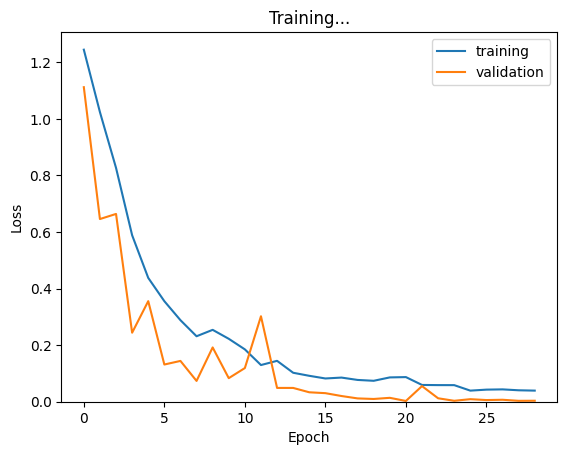

Early stopping


In [329]:
# Train function

import realtime_graph as graph

epochresults = []
epoch_valloss = 0 
graph.startplot()

for epoch in range(epochs):
    
    running_loss = 0.0
    running_valloss = 0.0

    transformersmodel.train()
    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        #-------------------------
        
        #forward pass
        outputs = transformersmodel.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)

    transformersmodel.eval() # prep model for evaluation
    epoch_vallos_previous = epoch_valloss
    for idx, data in enumerate(testloader):
        #forward pass
        outputs = transformersmodel.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        # record validation loss
        running_valloss += loss.item()
        

    epoch_valloss = running_valloss / len(testloader)


    epochresults.append([epoch_loss, epoch_valloss])

    
    graph.realtimeplot(epochresults)

    limit = 0.001    
    if epoch_vallos_previous-limit < epoch_valloss < epoch_vallos_previous+limit and epoch_loss<0.05:
        print("Early stopping")
        break

In [330]:
from sklearn.metrics import confusion_matrix
import numpy as np

correct = 0
total = 0
confusion_matrix = np.zeros((4, 4))  # Initialize the confusion matrix

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for idx, data in enumerate(dataset_test_loader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        # ---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        # -------------------------

        # calculate outputs by running images through the network
        outputs = transformersmodel.forward(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update confusion matrix
        for i in range(len(labels)):
            confusion_matrix[labels[i]][predicted[i]] += 1

print(f'Accuracy of the network on the test images: {100 * correct // total} %')
print('Confusion Matrix:')
print(confusion_matrix)

Accuracy of the network on the test images: 88 %
Confusion Matrix:
[[78.  0.  0.  1.]
 [ 1. 59.  0.  1.]
 [ 9.  1. 85.  8.]
 [14.  1.  0. 45.]]
